# Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6
import warnings
warnings.filterwarnings('ignore')

# Loading Dataset

In [2]:
data=pd.read_csv('AirPassengers.csv')
data

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
data['Month'].head()

0    1949-01
1    1949-02
2    1949-03
3    1949-04
4    1949-05
Name: Month, dtype: object

# Setting values for Months

In [4]:
data['Month']=data['Month'].apply(lambda x:dt(int(x[:4]),int(x[5:]),15))
data=data.set_index('Month')
data.head()
                                  

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


# Converting the data into time series data

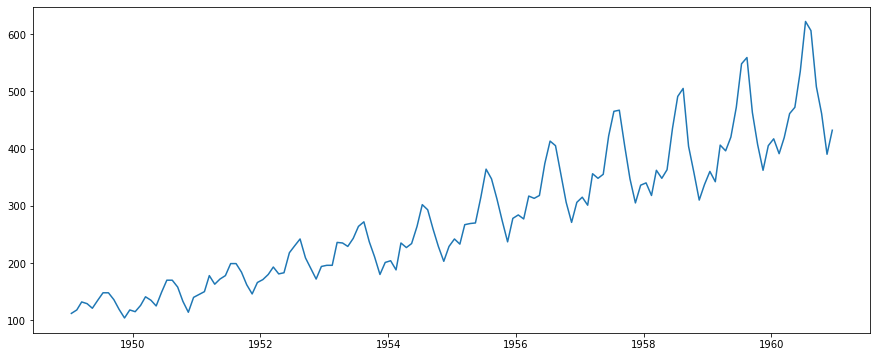

In [5]:
ts=data['#Passengers']
plt.plot(ts)

# Transforming the ts data into decomposed ts data

In [6]:
ts_log=np.log(ts)
ts_log

Month
1949-01-15    4.718499
1949-02-15    4.770685
1949-03-15    4.882802
1949-04-15    4.859812
1949-05-15    4.795791
                ...   
1960-08-15    6.406880
1960-09-15    6.230481
1960-10-15    6.133398
1960-11-15    5.966147
1960-12-15    6.068426
Name: #Passengers, Length: 144, dtype: float64

# Checking for stationarity

In [7]:
def test_stationarity(timeseries):
    rolmean=timeseries.rolling(window=52,center=False).mean() # this is the rolling mean
    rolstd=timeseries.rolling(window=52,center=False).std() # this is the rolling standard deviation
    original=plt.plot(timeseries,color='blue',label='original')
    mean=plt.plot(timeseries,color='red',label='rolling mean')
    std=plt.plot(timeseries,color='black',label='rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and std')
    plt.show()
    
    print('Result of Duckey_Fuller Test: ')
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Stationary','p-value','#Lags Used','Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value(%s)'%key]=value
        
    print(dfoutput)
    

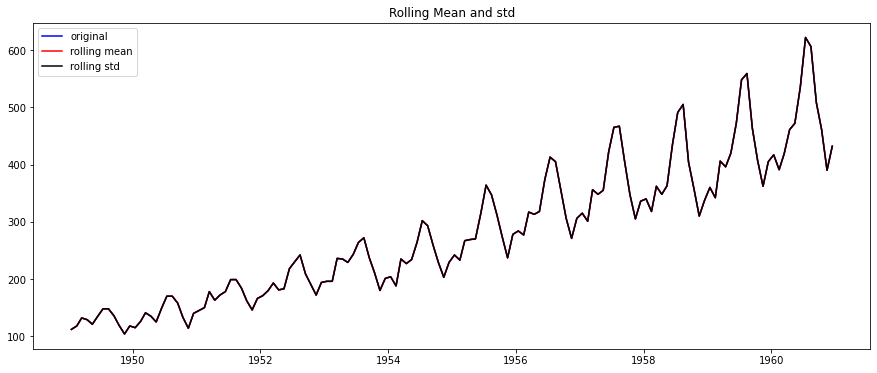

Result of Duckey_Fuller Test: 
Test Stationary                  0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value(1%)              -3.481682
Critical Value(5%)              -2.884042
Critical Value(10%)             -2.578770
dtype: float64


In [8]:
test_stationarity(data['#Passengers'])

# Plotting Moving Average

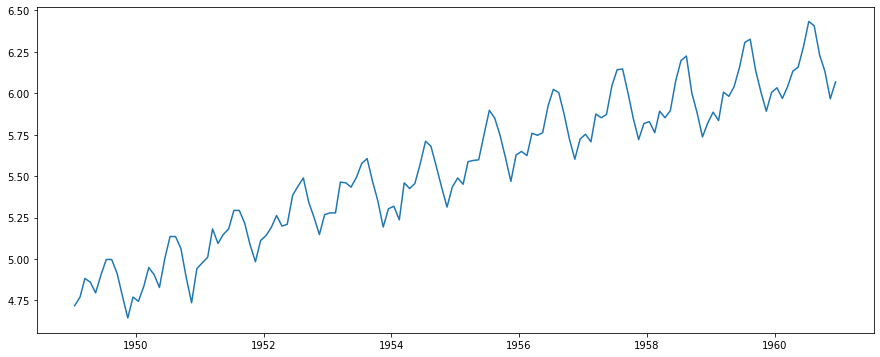

In [9]:
plt.plot(ts_log)

# Initializing moving average variables/std variables/plottings

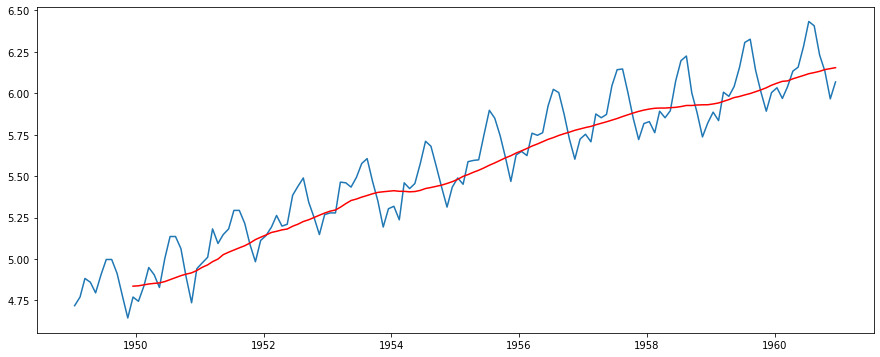

In [10]:
moving_average=ts_log.rolling(window=12).mean()
moving_std=ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(moving_average,color='red')

# Working on Differencing

In [11]:
ts_log_mv_diff=ts_log-moving_average
ts_log_mv_diff.head(12)

Month
1949-01-15         NaN
1949-02-15         NaN
1949-03-15         NaN
1949-04-15         NaN
1949-05-15         NaN
1949-06-15         NaN
1949-07-15         NaN
1949-08-15         NaN
1949-09-15         NaN
1949-10-15         NaN
1949-11-15         NaN
1949-12-15   -0.065494
Name: #Passengers, dtype: float64

In [12]:
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

# check for stationarity

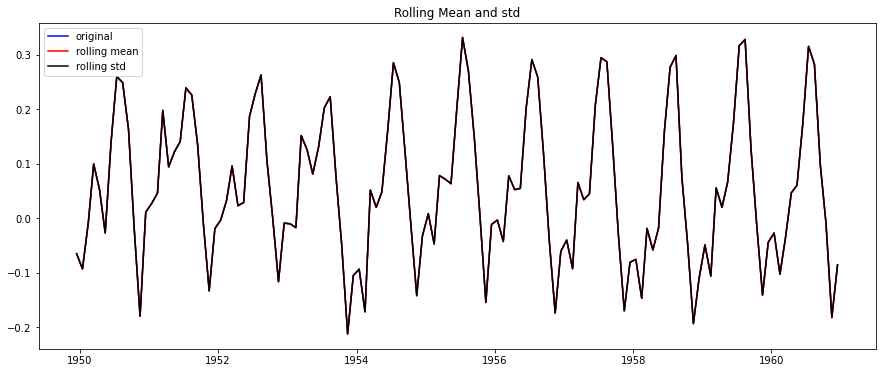

Result of Duckey_Fuller Test: 
Test Stationary                 -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value(1%)              -3.486535
Critical Value(5%)              -2.886151
Critical Value(10%)             -2.579896
dtype: float64


In [13]:
test_stationarity(ts_log_mv_diff)

# FORECASTING USING ARIMA MODELS

# Plotting ACF and applying calculated ACF

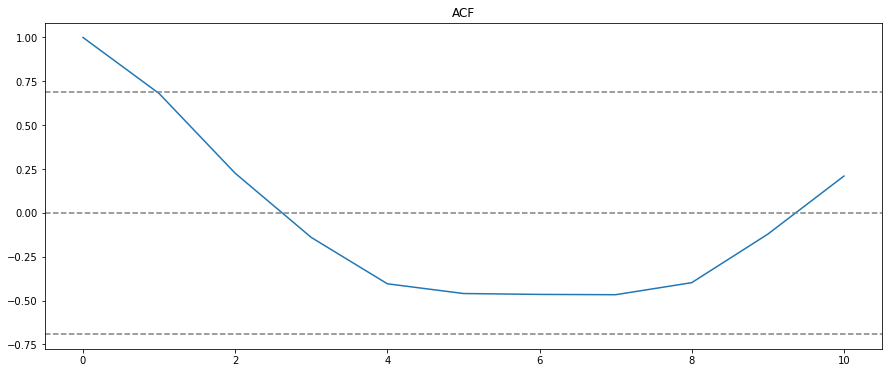

In [14]:
plt.plot(np.arange(0,11),acf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='grey')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='grey')
plt.title('ACF')
plt.show()

# Plotting PACF

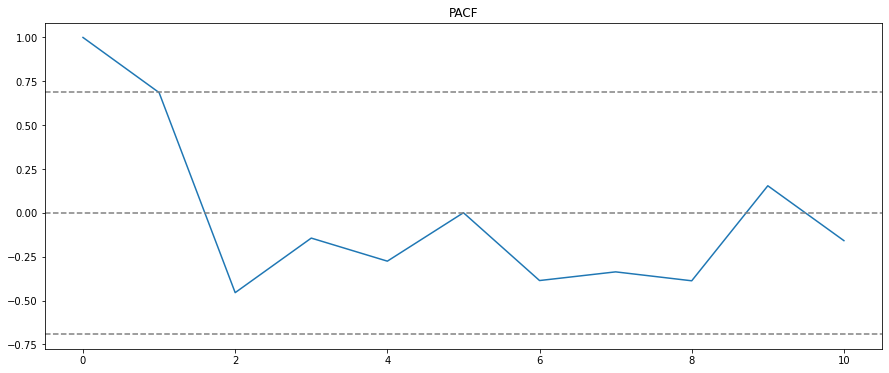

In [15]:
plt.plot(np.arange(0,11),pacf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='grey')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='grey')
plt.title('PACF')
plt.show()

# The Optimal Value of p in ARIMA

Text(0.5, 1.0, 'RSS:nan')

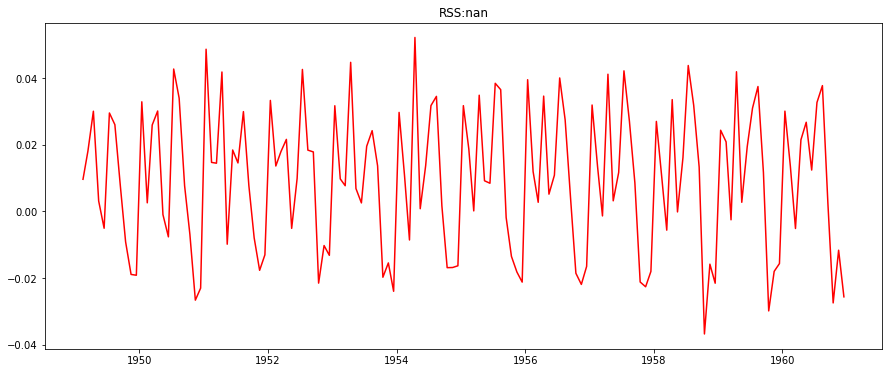

In [16]:
model=ARIMA(ts_log,order=(1,1,0))
result_ARIMA=model.fit(disp=-1)
plt.plot(result_ARIMA.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum(result_ARIMA.fittedvalues[:]-ts_log_mv_diff)**2)

# Model Prediction

In [17]:
prediction_ARIMA_diff=pd.Series(result_ARIMA.fittedvalues,copy=True)
prediction_ARIMA_diff.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

# Cumulative sum number of the predictions to check for accuracy

In [18]:
prediction_ARIMA_diff_cumsum=prediction_ARIMA_diff.cumsum()
prediction_ARIMA_diff_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

# Creating series with all values as base numbers (forecast of the original scale)

In [19]:
prediction_ARIMA_log=pd.Series(ts_log.iloc[0],index=ts_log.index)
prediction_ARIMA_log=prediction_ARIMA_log.add(prediction_ARIMA_diff_cumsum,fill_value=0)
prediction_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

# Initializing ARIMA model to produce the prediction (color orange) with RMSE

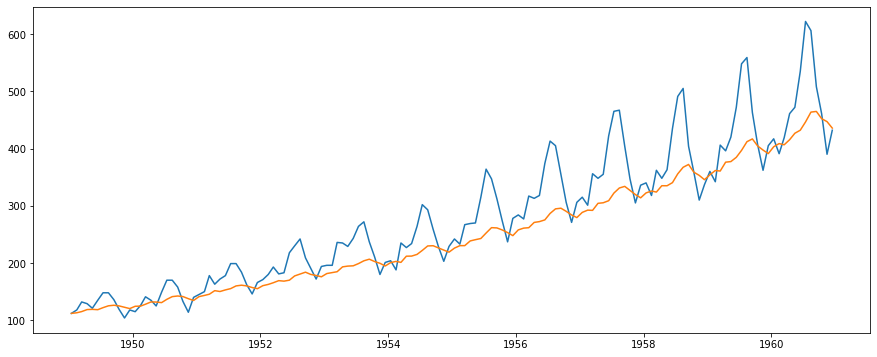

In [20]:
prediction_ARIMA=np.exp(prediction_ARIMA_log)
plt.plot(ts)
plt.plot(prediction_ARIMA)
#plt.title('RMSE: %.4f'% np.sqrt(sum(prediction_ARIMA - ts)**2)/len(ts))